### Dataset of the Sad Story:
We run the code to get the shape of both training and testing dataset on the raw data. The train dataset has 891 rows and 8 columns. The test dataset has 418 rows and 8 columns. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
#%matplotlib inline

# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Loading Datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [3]:
data_temp = train[['Ticket', 'Cabin']]
data_temp.head()


,Ticket,Cabin
0,A/5 21171,NaN
1,PC 17599,C85
2,STON/O2. 3101282,NaN
3,113803,C123
4,373450,NaN


In [4]:
# Check Datasets
train.shape
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# Calculate survivial rate
survived = train[train['Survived'] == 1]
not_survived = train[train['Survived'] == 0]

print ("Survived: %i (%.1f%%)"%(len(survived), float(len(survived))/len(train)*100.0))
print ("Not Survived: %i (%.1f%%)"%(len(not_survived), float(len(not_survived))/len(train)*100.0))
print ("Total: %i"%len(train))


Survived: 342 (38.4%)
Not Survived: 549 (61.6%)
Total: 891


## Exploratory Analysis

#### Analyze the features:
According to the raw data, the survival rate is 38.4%, and the non-survival rate is 61.6%. 
Just based on guessing, there is a 61.6% non-survival rate without applying any algorithm. However, the non-survival rate and survival rate should be approximately 80% and 20%. 


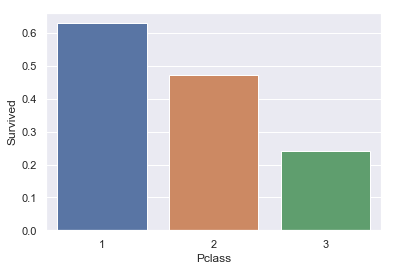

In [7]:
# Analyze Pclass data
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()
sns.barplot(x='Pclass', y='Survived', ci=None, data=train)


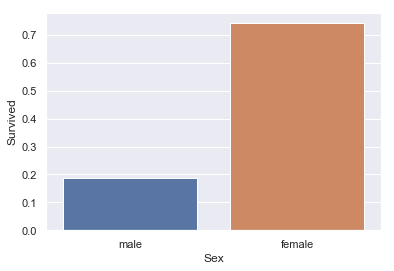

In [8]:
# Analyze Sex data
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()
sns.barplot(x='Sex', y='Survived', ci=None, data=train)


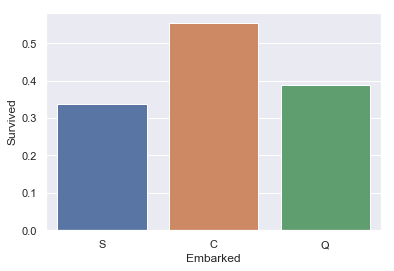

In [9]:
# Analyze Embarked data
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', ci=None, data=train)


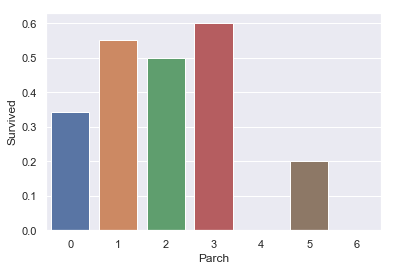

In [10]:
# Analyze Parent-Children data
train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean()
sns.barplot(x='Parch', y='Survived', ci=None, data=train)


The above figure shows the relationship between survival rate and children or parents travel with each passenger. 

The survival rate for 3 Parch is the highest (60%).

The survival rate for 6 Parch is the lowest (0%). 

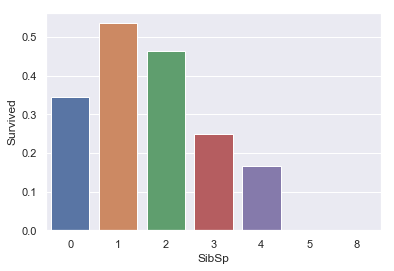

In [11]:
# Analyze Sibling data
train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()
sns.barplot(x='SibSp', y='Survived', ci=None, data=train) 

The above figure shows the relationship between the survival rate and SibSp (spouse or siblings travel with each passenger). The survival rate is the highest (53.6%) if the passenger travels with one spouse. The survival rate is lowest (0%) if the passenger travels with 5 and 8 spouse.  

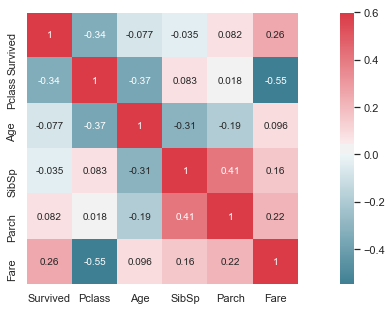

In [12]:
# Correlating Features
plt.figure(figsize=(15,5))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(train.drop('PassengerId',axis=1).corr(), cmap=colormap, vmax=0.6, square=True, annot=True)


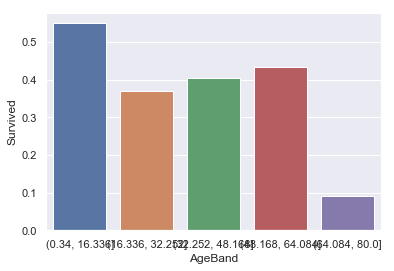

In [13]:
# Categorizes age into 5 different age range   
train['AgeBand'] = pd.cut(train['Age'], 5)

# Does age make a difference
sns.barplot(x='AgeBand', y='Survived', ci=None, data=train)

Ageband: the age is segregated into five groups. 

The first group (age 0 to 16), has the highest survival rate. Younger passengers have higher survival rate. The oldest passengers don’t have enough strengths to run and catch up the boat so that they have lowest survival rate. 

## Cleansing
Let's begin the cleaning process

This process includes:
    1. fill in null values
    2. drop features

In [14]:
# Combine train and test Datasets
train_test_data = [train, test] 

In [15]:
# Complete Datasets
for dataset in train_test_data:
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    
train.isnull().sum() # I will drop Cabin and Ageband, so don't worry about the missing values for this two features.

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
AgeBand        177
dtype: int64

In [16]:
# Extract titles from Name column. 
for dataset in train_test_data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.')


In [17]:
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [18]:
# Replace some less common titles with the name "Other"
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', \
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()


,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Other,0.347826


In [19]:
# Convert the categorical Title values into numeric form
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)    
  

In [20]:
# Convert Sex data
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)    
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

The figure show above is the code we used to convert Sex and Embarked to numeric value. In Sex, female is converted to 1 and male is converted to 0. Similarly, in Embarked, S = 0, C = 1, Q = 2. The object data type can’t be converted so all object data needs to be dropped. In this case, we dropped PassengerId, Name, and Ticket columns. We also dropped Cabin because it does not have enough information. 

In [21]:
# Create FamilySize
for dataset in train_test_data:
    dataset['FamilySize'] = dataset['SibSp'] +  dataset['Parch'] + 1

print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())


   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


In [22]:
# Create a new feature named IsAlone
for dataset in train_test_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


In [23]:
# Replace missing Fare values with the median of Fare
for dataset in train_test_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median()) 

# Create 4 FareBands
train['FareBand'] = pd.qcut(train['Fare'], 4)
print (train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean())


          FareBand  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


In [24]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.361582,0.523008,0.381594,32.204208,0.361392,1.728395,1.904602,0.602694
std,257.353842,0.486592,0.836071,0.477990,13.019697,1.102743,0.806057,49.693429,0.635673,1.030039,1.613459,0.489615
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,1.000000,1.000000,0.000000
50%,446.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000,1.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000,2.000000,2.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,5.000000,11.000000,1.000000


In [25]:
# Drop unnecessary columns/features 
features_drop = ['SibSp','Parch','Title','FamilySize']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
#train = train.drop(['PassengerId', 'AgeBand', 'FareBand'], axis=1)


In [26]:
#54: Define training and testing set
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_test = test.drop("PassengerId", axis=1).copy()

X_train.head()
y_train.head()
X_train.shape, y_train.shape, X_test.shape


((891, 12), (891,), (418, 9))

## Models

In [ ]:
# Logistic Regression 
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred_log_reg = clf.predict(X_test)
acc_log_reg = round( clf.score(X_train, y_train) * 100, 2)
print (str(acc_log_reg) + ' percent')    

79.01 Percent

In [ ]:
# Decision Tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred_decision_tree = clf.predict(X_test)
acc_decision_tree = round(clf.score(X_train, y_train) * 100, 2)
print (acc_decision_tree)

In [ ]:
# Random Forest
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred_random_forest = clf.predict(X_test)
acc_random_forest = round(clf.score(X_train, y_train) * 100, 2)
print (acc_random_forest)

Decision Tree and Randomd Forest = 85.63 Percent